In [1]:
from astropy.io import fits
from astropy.table import Table, QTable
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import sqrt, log10
from astropy.io import ascii
import astropy.io

from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
#Open the appropriate fits file, extract relevant data, close file
hdul = fits.open('c:\\users\\sahal\\2018TrinaryWork\\gaiadr2_OrionTables.fits')
pmra_all = hdul[1].data['pmra'] / 3600000 #pmra is in mas/yr - converts to deg/yr
pmdec_all = hdul[1].data['pmdec'] / 3600000 #pmdec is in mas/yr - converts to deg/yr
radial_velocity_all = hdul[1].data['radial_velocity'] #radial velocity is in mas/yr? or parsec/yr?
source_id_all = hdul[1].data['source_id']
ra_all = hdul[1].data['ra'] #ra in deg
dec_all = hdul[1].data['dec'] #dec in deg
parallax_all = hdul[1].data['parallax'] #parallax in mas

G_all = hdul[1].data['phot_g_mean_mag'] #magnitudes in G filter
Gb_all = hdul[1].data['phot_bp_mean_mag']#magnitudes in Gbp filter
Gr_all = hdul[1].data['phot_rp_mean_mag']#magnitudes in Brp filter

bp_rp_all = hdul[1].data['bp_rp']#color difference b-r
#This is the same as subtracting Gb - Gr

ra_err_all = hdul[1].data['ra_error']
dec_err_all = hdul[1].data['dec_error']
pmra_err_all = hdul[1].data['pmra_error']
pmdec_err_all = hdul[1].data['pmdec_error']

parallax_err_all = hdul[1].data['parallax_error']
rv_err_all = hdul[1].data['radial_velocity_error']

hdul.close()

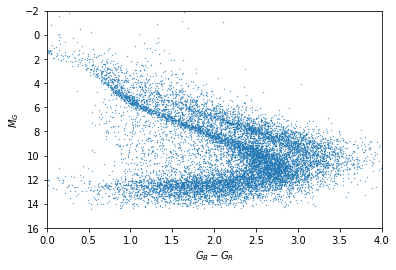

In [3]:
#Absolute magnitude in terms of G and p
Mg_all = [G + 5 - 5*(log10(1000/p)) for G, p in zip(G_all, parallax_all)]
#p is in mas so we divide the listed 1000 by 10

plt.plot(bp_rp_all, Mg_all, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(16,-2)
plt.xlabel("$G_B - G_R$")
plt.ylabel("$M_G$")
plt.show()

In [4]:
#Get the indices ii of all values for stars that satisfy appropriate photometric conditions
ii = []

for i in range(len(source_id_all)):
    if( (Mg_all[i]<2.46*(bp_rp_all[i])+2.76 and .3<(bp_rp_all[i])<1.8)
       or (Mg_all[i]<2.8*(bp_rp_all[i])+2.16 and 1.8<(bp_rp_all[i]))):
       #or (Mg_all[i]>2.14*(bp_rp_all[i])-.57 and .5<(bp_rp_all[i])<1.2)
       #or (Mg_all[i]>1.11*(bp_rp_all[i])+.66 and 1.2<(bp_rp_all[i])<3)):
        ii.append(i)
        
print(len(ii))

4022


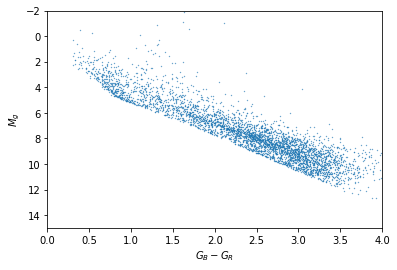

In [5]:
#Redefine our data as all stars that fit photometric parameters of young stars
pmra = pmra_all[ii]
pmdec = pmdec_all[ii]
radial_velocity = radial_velocity_all[ii]
source_id = source_id_all[ii]
ra = ra_all[ii]
dec = dec_all[ii]
parallax = parallax_all[ii]

G = G_all[ii]
Gb = Gb_all[ii]
Gr = Gr_all[ii]

bp_rp = bp_rp_all[ii]

ra_err = ra_err_all[ii]
dec_err = dec_err_all[ii]
pmra_err = pmra_err_all[ii]
pmdec_err = pmdec_err_all[ii]

parallax_err = parallax_err_all[ii]
rv_err = rv_err_all[ii]

#############################

Mg = [G + 5 - 5 * log10(1000/p) for G, p in zip(G, parallax)]

plt.plot(bp_rp, Mg, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(15,-2)
plt.xlabel("$G_B - G_R$")
plt.ylabel("$M_g$")
plt.show()

In [6]:
def toffset(pmra, pmdec, dt):
    return (pmra * dt, pmdec * dt)

def dist(ra, dec):
    return np.array([np.sqrt( (ra[i]-ra)**2 +  (dec[i]-dec)**2 ) for i in range(len(ra))])

arcsec = 1 / 3600
def updated(ra_in, dec_in, pmra_in, pmdec_in, tstep):
    pmraProj, pmdecProj = toffset(pmra_in, pmdec_in, tstep)
    ra_t = ra_in + pmraProj
    dec_t = dec_in + pmdecProj
    
    alldists = dist(ra_t,dec_t)
    
    successfulMatch = np.where((alldists < arcsec) & (alldists != 0.))
    
    return [tstep,successfulMatch[0]]    


This has been extracted in previous work, so to save running time I pick up with a .npz file containing the timesteps and raw indices of stars

In [7]:
fnam = 'c:\\users\\sahal\\2018trinarywork\\jupyterfiles\\timecoords.npz'
inVals = np.load(fnam) #has entries ['time'] and ['ind']

tts = inVals['time']
iind = inVals['ind']

tts = np.flip(tts,0)
iind = np.flip(iind,0)


ta = Table([tts, np.array(iind)], names = ('times', 'inds'), meta = {'name': 'IndTable'})
ta.remove_rows(slice(0,4))#I accidentally projected a few years in the future so this cuts the timesteps off at 0
tts = ta['times']
iinds = ta['inds']

In [8]:
################################################################################
#Now match them up by distance:
################################################################################

def getCoords(ra,dec, pmra, pmdec, t):
    if t != 0:
        pmra_atT = pmra * t
        pmdec_atT = pmdec * t
    else:
        pmra_atT = pmra
        pmdec_atT = pmdec

    ra_atT = ra + pmra_atT
    dec_atT = dec + pmdec_atT
    return [ra_atT, dec_atT, pmra, pmdec]

def dist(ra, dec):
    return np.array([np.sqrt( (ra[i]-ra)**2 +  (dec[i]-dec)**2 ) for i in range(len(ra))])

arcsec = 1/3600
for mm in range(len(ta)):
    chunk = ta['inds'][mm]
    tim = ta['times'][mm]
    coords = getCoords(ra, dec, pmra, pmdec,tim)
    if not (len(chunk) > 2):
        ta['inds'][mm] = [list(chunk)]
    else:
        mat = dist(coords[0][chunk], coords[1][chunk])
        a, b = mat.shape
        sel = np.tril_indices(a)
        mat[sel] = 0

        rawlist = list(np.where((mat < arcsec) & (mat != 0)))
        rawlist = [list(i) for i in rawlist]
        xs = [[chunk[i], chunk[j]] for i, j in zip(rawlist[0], rawlist[1])]
        ta['inds'][mm] = xs

In [9]:
flattened = []
timesflat = []
for ind in range(len(ta['inds'])):
    entry = ta['inds'][ind]
    tt = ta['times'][ind]
    for i in entry:
        timesflat.append(tt)
        flattened.append(i)

tab = Table([timesflat, np.array(flattened)], names = ('times', 'ind'), meta = {'name': 'UpdatedTable'})

datlist = tab['ind']
tilist = tab['times']
checklist = np.array([str(cc) for cc in flattened])

selectRows = []
for entry in checklist:
    b = np.where(checklist == entry)[0]
    dlist = []
    for i in b:
        indPairs = datlist[i]
        ra_b, dec_b = getCoords(ra[indPairs], dec[indPairs], pmra[indPairs], pmdec[indPairs], tilist[i])[0:2]
        ds = dist(ra_b, dec_b)[0][1]
        dlist.append(ds)
    selector = np.argmin(dlist)
    cval = b[selector]
    selectRows.append(int(cval))

selectRows = list(set(selectRows))
selectRows.sort()

tabtimes = [tilist[i] for i in selectRows]
tabinds = [[datlist[i]] for i in selectRows]

tabl = Table([tabtimes, tabinds], names = ('Time', 'Indices'), meta = {'name': 'SortedVals'})
#tabl.show_in_notebook()
print(tabl)

  Time  Indices [1,2]
------- -------------
   -400    604 .. 608
   -900  3173 .. 3201
  -1700  3965 .. 3966
  -2000    971 .. 972
  -2600  1015 .. 1017
  -3600  2418 .. 2419
  -4200  1274 .. 1275
  -4300  3491 .. 3503
  -4500    197 .. 198
  -4700  3450 .. 3493
    ...           ...
-954800  1286 .. 1733
-955100   280 .. 2337
-957400  1445 .. 3328
-958400  2014 .. 2248
-962500  3662 .. 3914
-965300    625 .. 712
-969900   157 .. 2408
-971400    689 .. 985
-975600  1326 .. 2439
-978600  2911 .. 3281
-983700  3383 .. 3568
Length = 440 rows


In [10]:
def getParallelMotion(inds):
    s1 = inds[0]
    s2 = inds[1]
    vec1 = np.array([pmra[s1], pmdec[s1]])
    vec2 = np.array([pmra[s2], pmdec[s2]])
    intr = vec1/2 + vec2/2
    return intr * 3600 * 1000 #Converts to miliarcseconds per year

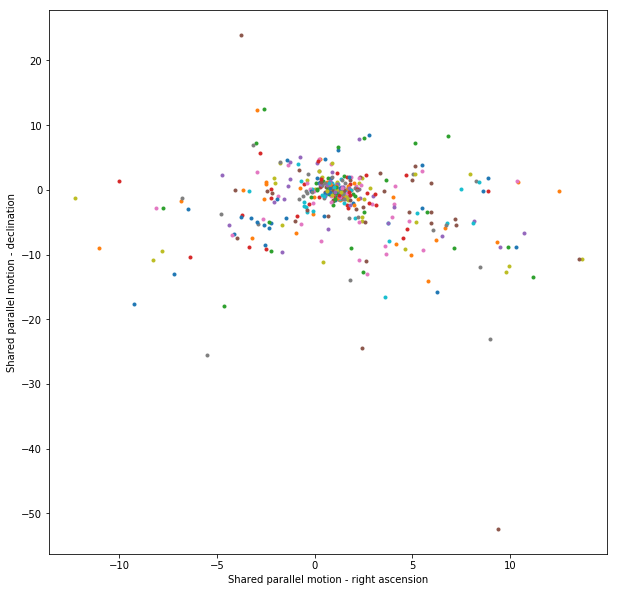

In [11]:
fig, axs = plt.subplots(figsize = (10,10))
for chunk in tabl['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

In [12]:
tabRa1 = []
tabRa2 = []
tabDec1 = []
tabDec2 = []
tabPmra1 = []
tabPmra2 = []
tabPmdec1 = []
tabPmdec2 = []

tabRaInitial1 = []
tabDecInitial1 = []
tabRaInitial2 = []
tabDecInitial2 =[]

tabPar1 = []
tabPar2 = []

tabRv1 = []
tabRv2 = []

ref_pmra = []
ref_pmdec = []

tabRa_err1 = []
tabDec_err1 = []
tabPmra_err1 = []
tabPmdec_err1 = []

tabRa_err2 = []
tabDec_err2 = []
tabPmra_err2 = []
tabPmdec_err2 = []

tabPar_err1 = []
tabRv_err1 = []
tabPar_err2 = []
tabRv_err2 = []

tabAbs_g1 = []
tabBp_rp1 = []
tabAbs_g2 = []
tabBp_rp2 = []

tabTime = []


for i in range(len(tabl)):
    inds = tabl['Indices'][i]
    inds = inds[0]
    time = tabl['Time'][i]
    
    tProject = getCoords(ra[inds], dec[inds], pmra[inds], pmdec[inds], time)
    vec = getParallelMotion(inds)
    
    tabTime.append(time)
    tabRa1.append(tProject[0][0]) #ra1
    tabDec1.append(tProject[1][0]) #dec1
    tabPmra1.append(tProject[2][0] * 3600 * 1000) #pmra1
    tabPmdec1.append(tProject[3][0] * 3600 * 1000) #pmdec1
    
    tabRa2.append(tProject[0][1]) #ra2
    tabDec2.append(tProject[1][1]) #dec2
    tabPmra2.append(tProject[2][1] * 3600 * 1000) #pmra2
    tabPmdec2.append(tProject[3][1] * 3600 * 1000) #pmdec2
    
    #These down could be done outside of the loop
    tabRaInitial1.append(ra[inds[0]])
    tabDecInitial1.append(dec[inds[0]])
    tabRaInitial2.append(ra[inds[1]])
    tabDecInitial2.append(dec[inds[1]])
    
    
    tabPar1.append(parallax[inds[0]]) #parallax1
    tabPar2.append(parallax[inds[1]]) #parallax2
    
    tabRv1.append(radial_velocity[inds[0]])
    tabRv2.append(radial_velocity[inds[1]])
    
    ref_pmra.append(vec[0]) #Add these to the table
    ref_pmdec.append(vec[1])
    
    tabAbs_g1.append(G[inds[0]])
    tabAbs_g2.append(G[inds[1]])
    tabBp_rp1.append(bp_rp[inds[0]])
    tabBp_rp2.append(bp_rp[inds[1]])
    
    tabRa_err1.append(ra_err[inds[0]])
    tabDec_err1.append(dec_err[inds[0]])
    tabPmra_err1.append(pmra_err[inds[0]])
    tabPmdec_err1.append(pmdec_err[inds[0]])

    tabRa_err2.append(ra_err[inds[1]])
    tabDec_err2.append(dec_err[inds[1]])
    tabPmra_err2.append(pmra_err[inds[1]])
    tabPmdec_err2.append(pmdec_err[inds[1]])
    
    tabPar_err1.append(parallax_err[inds[0]])
    tabPar_err2.append(parallax_err[inds[1]])
    tabRv_err1.append(rv_err[inds[0]])
    tabRv_err2.append(rv_err[inds[1]])
    
populatedTable = Table(
    [tabRaInitial1, tabDecInitial1, tabPmra1, tabPmdec1, tabRa1, tabDec1, tabPar1, tabRv1,tabAbs_g1, tabBp_rp1,
     tabRa_err1, tabDec_err1, tabPmra_err1, tabPmdec_err1, tabPar_err1, tabRv_err1,
     
     tabRaInitial2, tabDecInitial2, tabPmra2, tabPmdec2, tabRa2, tabDec2, tabPar2, tabRv2, tabAbs_g2, tabBp_rp2,
     tabRa_err2, tabDec_err2, tabPmra_err2, tabPmdec_err2, tabPar_err2, tabRv_err2,
     ref_pmra, ref_pmdec, tabTime],    
    names = ('ra1', 'dec1', 'pmra1', 'pmdec1', 'projected_ra1', 'projected_dec1', 'parallax1', 'rVelocity1', 'G1', 'bprp1',
             'ra_err1', 'dec_err1', 'pmra_err1', 'pmdec_err1', 'parralax_err1', 'rv_err1',
             'ra2', 'dec2', 'pmra2', 'pmdec2', 'projected_ra2', 'projected_dec2', 'parallax2', 'rVelocity2', 'G2', 'bprp2',
             'ra_err2', 'dec_err2', 'pmra_err2', 'pmdec_err2', 'parralax_err2', 'rv_err2',
             'ref_pmra', 'ref_pmdec', 'time'),
    meta = {'name': 'CompleteTable'})

In [13]:
populatedTable #Note radial velocities are often nan

ra1,dec1,pmra1,pmdec1,projected_ra1,projected_dec1,parallax1,rVelocity1,G1,bprp1,ra_err1,dec_err1,pmra_err1,pmdec_err1,parralax_err1,rv_err1,ra2,dec2,pmra2,pmdec2,projected_ra2,projected_dec2,parallax2,rVelocity2,G2,bprp2,ra_err2,dec_err2,pmra_err2,pmdec_err2,parralax_err2,rv_err2,ref_pmra,ref_pmdec,time
float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int32
83.48251170091393,-4.797265264995391,0.6447739881206371,0.946648818204142,83.4824400593597,-4.797370448197414,2.446124574615641,nan,16.8622,2.7225971,0.0975906924092268,0.09586025503680433,0.2411820526140304,0.1982581688380465,0.13176411603228833,nan,83.48253321864347,-4.797049560919736,-0.07499483289390126,1.3499021915126073,83.48254155140268,-4.7971995500521265,2.479931510507315,nan,16.948454,2.6344328,0.1091233109154024,0.10085048692611268,0.2713176242934988,0.2537414393881067,0.13401914755570907,nan,0.284889577613368,1.1482755048583748,-400
84.53876810637198,-6.821279333750583,0.24341211743322042,-0.5376869219573865,84.53870725334262,-6.8211449120200935,2.555351015682546,nan,13.023477,2.278349,0.03657946680206794,0.043071152775523674,0.08480524907547862,0.08690065435335688,0.05314236868699175,nan,84.53840611426924,-6.824308421585931,-2.1650734999397305,-12.71708095634933,84.53894738264422,-6.8211291513468435,2.381508354627957,nan,18.831034,3.316311,0.218529866356268,0.24742385187365107,0.5494369682820555,0.5891574911896434,0.3027479997254582,nan,-0.9608306912532552,-6.627383939153358,-900
84.50349454157684,-7.264919768031094,-0.010701943245293588,1.3953914020712481,84.50349959527226,-7.26557870285985,3.152727556491071,nan,15.249276,2.1309347,0.09954479511210143,0.0933556609361285,0.24836261730137532,0.20048602022075482,0.13085510796305624,nan,84.50335136108642,-7.265221329201588,0.11152819090463771,0.8443734708342436,84.50329869499626,-7.265620061118371,2.6833273594620985,nan,15.752002,2.3069115,0.08932226618754684,0.08195359697557524,0.19207466954507768,0.16359151484472476,0.10607502368011383,nan,0.050413123829672064,1.119882436452746,-1700
84.08028325875834,-5.0079025103820145,1.9289053108034433,0.10875771429393918,84.07921164469678,-5.0079629313344,2.380364991994506,nan,17.38141,3.2439833,0.09092217957386244,0.09248528687591666,0.22757602112369593,0.23283750486366234,0.11973001911974872,nan,84.07983711301937,-5.010653864554236,1.416340135215205,-4.906162244794249,84.07905025738869,-5.007928218862683,2.1517806811876303,nan,16.9702,2.341385,0.060584980841551686,0.061652922293499036,0.1503192418278543,0.1531460075089603,0.07901936980633972,nan,1.6726227230093242,-2.398702265250155,-2000
83.85776095102422,-5.132364341100109,3.525223471317901,-0.6938061298633568,83.85521495629493,-5.131863258895208,2.507368734750781,nan,14.307585,2.1879883,0.02545239424027045,0.027579579759516835,0.058046045197556996,0.05561210751701419,0.03437069040242561,nan,83.85690201927144,-5.132569536849398,2.4404869156115954,-1.1889684760861023,83.85513944538795,-5.131710837394447,2.671313954363518,nan,15.432099,3.105173,0.08750562534712117,0.09272331631182928,0.20602097167940933,0.18852674170235675,0.12109833413754126,nan,2.982855193464748,-0.9413873029747294,-2600
83.34410194171222,-5.544440845586294,0.6748556793650204,-0.5098740984182977,83.34342708603286,-5.5439309714878755,2.5627001622811405,nan,15.797495,2.4328175,0.04052977143774015,0.04396736644833838,0.09414459566951451,0.09660420650968513,0.06300865240435996,nan,83.34336921538706,-5.5426058067787745,-0.1759589082098121,1.241023365508144,83.34354517429527,-5.5438468301442825,3.3059120378334512,nan,13.9214325,1.8929348,0.17341219875726513,0.18472373843051418,0.4015471224687479,0.3930374821598586,0.26108914422589574,nan,0.24944838557760418,0.3655746335449231,-3600
83.80750024239218,-5.368619012600222,-0.044086781065910796

In [14]:
#populatedTable.write('MatchedPairData.fits', format = 'fits', overwrite = True)

This is where I make a hard shift to working with the fake data:
-------------------------------------------------------------

In [15]:
fake1 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake1.fits')
fake2 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake2.fits')
fake3 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake3.fits')
fake4 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake4.fits')
fake5 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake5.fits')
fake6 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake6.fits')
fake7 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake7.fits')
fake8 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake8.fits')
fake9 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake9.fits')
fake10 = Table.read('c:\\Users\\sahal\\2018TrinaryWork\\Archive\\fake10.fits')
fake1.info

<Table length=3996>
  name    dtype  n_bad
-------- ------- -----
      RA float64     0
     DEC float64     0
    PMRA float32     0
   PMDEC float32     0
PARALLAX float32     0
      RV float32   131
    ABSG float32     0
    ABSH float32     0
   BP_RP float32     0
     YSO float32     0

In [16]:

mg = [G + 5 - 5*(log10(1000/p)) for G, p in zip(fake1['ABSG'], fake1['PARALLAX'])]

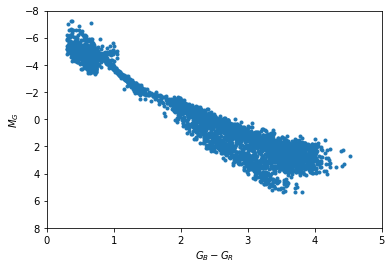

In [17]:
plt.plot(fake1['BP_RP'],mg, '.')
plt.xlim(0,5)
plt.ylim(8,-8)
plt.xlabel("$G_B - G_R$")
plt.ylabel("$M_G$")
plt.show()

In [18]:
def perFake(fName):
    raF = fName['RA'] 
    decF = fName['DEC']
    pmraF = fName['PMRA'] / 3600000
    pmdecF = fName['PMDEC'] / 3600000
    matches = []
    for ts in range(-1000000, 1000, 1000):
        val = updated(raF, decF, pmraF, pmdecF,ts)
        print(val[0], val[1])
        if val[1].size > 0:
            matches.append(val)
    return matches

In [19]:
"""fake1Tab = perFake(fake1)
fake2Tab = perFake(fake2)
fake3Tab = perFake(fake3)
fake4Tab = perFake(fake4)"""
#These have already been saved to files

"""
fake5Tab = perFake(fake5)
fake6Tab = perFake(fake6)
fake7Tab = perFake(fake7)
fake8Tab = perFake(fake8)"""


"""fake9Tab = perFake(fake9)"""
fake10Tab = perFake(fake10)

-1000000 []
-999000 []
-998000 []
-997000 []
-996000 [2905 3336]
-995000 [1626 3305]
-994000 []
-993000 [1247 1293]
-992000 []
-991000 []
-990000 []
-989000 []
-988000 []
-987000 []
-986000 [2172 2250 2428 2831]
-985000 []
-984000 []
-983000 []
-982000 [ 706 1727]
-981000 [3103 3347]
-980000 [ 239 1977 1989 2784 2856 3479]
-979000 []
-978000 []
-977000 []
-976000 []
-975000 []
-974000 []
-973000 [2425 3820]
-972000 []
-971000 []
-970000 []
-969000 []
-968000 [2127 2950]
-967000 [2127 2950]
-966000 []
-965000 []
-964000 []
-963000 []
-962000 []
-961000 [1790 2278]
-960000 []
-959000 []
-958000 []
-957000 [1760 3072]
-956000 [1760 2548 2947 3072]
-955000 []
-954000 [ 732 2983]
-953000 []
-952000 [1944 3765]
-951000 []
-950000 [1897 3963]
-949000 []
-948000 []
-947000 []
-946000 []
-945000 [1590 3212]
-944000 []
-943000 []
-942000 []
-941000 []
-940000 []
-939000 [1472 1787]
-938000 []
-937000 []
-936000 []
-935000 []
-934000 [ 686 1336 2346 3111]
-933000 [1336 2346]
-932000 []
-931000 [ 

-395000 []
-394000 []
-393000 [1306 1917 1977 2947]
-392000 []
-391000 []
-390000 []
-389000 []
-388000 []
-387000 []
-386000 [3145 3700]
-385000 []
-384000 []
-383000 [ 821 1597]
-382000 [1242 2646 3703 3895]
-381000 []
-380000 []
-379000 []
-378000 []
-377000 []
-376000 []
-375000 []
-374000 [2008 2173 2445 2687]
-373000 []
-372000 []
-371000 [1434 1894]
-370000 []
-369000 [  55 3216]
-368000 [1438 1566]
-367000 [1438 1566]
-366000 []
-365000 []
-364000 [1298 1973 2923 3621]
-363000 []
-362000 [1803 2473]
-361000 []
-360000 []
-359000 []
-358000 []
-357000 [1702 3313]
-356000 []
-355000 []
-354000 []
-353000 [2480 2970]
-352000 [2480 2970]
-351000 [2265 2680]
-350000 [2265 2680]
-349000 [ 408 1480]
-348000 [1817 2278]
-347000 [1817 2258 2278 3596]
-346000 []
-345000 [3762 3822]
-344000 []
-343000 []
-342000 []
-341000 []
-340000 []
-339000 []
-338000 []
-337000 []
-336000 [2718 2805]
-335000 [ 351 2010 2473 2911]
-334000 []
-333000 []
-332000 []
-331000 []
-330000 []
-329000 [1649 38

In [20]:
"""a = np.array([fake1Tab[i][0] for i in range(len(fake1Tab))])
b = np.array([fake1Tab[i][1] for i in range(len(fake1Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake1pairs.npz', time = a, ind = b)

a = np.array([fake2Tab[i][0] for i in range(len(fake2Tab))])
b = np.array([fake2Tab[i][1] for i in range(len(fake2Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake2pairs.npz', time = a, ind = b)

a = np.array([fake3Tab[i][0] for i in range(len(fake3Tab))])
b = np.array([fake3Tab[i][1] for i in range(len(fake3Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake3pairs.npz', time = a, ind = b)

a = np.array([fake4Tab[i][0] for i in range(len(fake4Tab))])
b = np.array([fake4Tab[i][1] for i in range(len(fake4Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake4pairs.npz', time = a, ind = b)"""
#These files take ~an hour to produce so don't alter them

"""a = np.array([fake5Tab[i][0] for i in range(len(fake5Tab))])
b = np.array([fake5Tab[i][1] for i in range(len(fake5Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake5pairs.npz', time = a, ind = b)

a = np.array([fake6Tab[i][0] for i in range(len(fake6Tab))])
b = np.array([fake6Tab[i][1] for i in range(len(fake6Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake6pairs.npz', time = a, ind = b)

a = np.array([fake7Tab[i][0] for i in range(len(fake7Tab))])
b = np.array([fake7Tab[i][1] for i in range(len(fake7Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake7pairs.npz', time = a, ind = b)

a = np.array([fake8Tab[i][0] for i in range(len(fake8Tab))])
b = np.array([fake8Tab[i][1] for i in range(len(fake8Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake8pairs.npz', time = a, ind = b)"""

"""a = np.array([fake9Tab[i][0] for i in range(len(fake9Tab))])
b = np.array([fake9Tab[i][1] for i in range(len(fake9Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake9pairs.npz', time = a, ind = b)"""

"""a = np.array([fake10Tab[i][0] for i in range(len(fake10Tab))])
b = np.array([fake10Tab[i][1] for i in range(len(fake10Tab))])
np.savez('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake10pairs.npz', time = a, ind = b)"""
print('All have been run')

All have been run


In [21]:
f1 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake1pairs.npz')
f2 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake2pairs.npz')
f3 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake3pairs.npz')
f4 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake4pairs.npz')

f5 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake5pairs.npz')
f6 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake6pairs.npz')
f7 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake7pairs.npz')
f8 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake8pairs.npz')
f9 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake9pairs.npz')
f10 = np.load('c:\\users\\sahal\\2018TrinaryWork\\archive\\fake10pairs.npz')

In [22]:
def allSteps(ff, readIn): #ff is the npz file, readIn is the read-in fits file
    times = ff['time']
    inds = ff['ind']

    times = np.flip(times,0)
    inds = np.flip(inds,0)

    ftab = Table([times, inds], names = ('times', 'ind'))
    print(ftab)
    
    #Replicate old steps, yes this is confusing
    for mm in range(len(ftab)):
        chunk = ftab['ind'][mm]
        tim = ftab['times'][mm]
        coords = getCoords(readIn['RA'], readIn['DEC'], readIn['PMRA']/ 3600000, readIn['PMDEC']/ 3600000,tim)
        if not (len(chunk) > 2):
            ftab['ind'][mm] = [list(chunk)]
        else:
            mat = dist(coords[0][chunk], coords[1][chunk])
            a, b = mat.shape
            sel = np.tril_indices(a)
            mat[sel] = 0

            rawlist = list(np.where((mat < arcsec) & (mat != 0)))
            rawlist = [list(i) for i in rawlist]
            xs = [[chunk[i], chunk[j]] for i, j in zip(rawlist[0], rawlist[1])]
            ftab['ind'][mm] = xs
    print(ftab)
    
    #############################################
    
    
    flattened = []
    timesflat = []
    for ind in range(len(ftab['ind'])):
        entry = ftab['ind'][ind]
        tt = ftab['times'][ind]
        for i in entry:
            timesflat.append(tt)
            flattened.append(i)
            
    ftab2 = Table([timesflat, np.array(flattened)], names = ('times', 'ind'))
    print(ftab2)
    
    ###################
    
    datlist = ftab2['ind']
    tilist = ftab2['times']
    checklist = np.array([str(cc) for cc in flattened])

    selectRows = []
    for entry in checklist:
        b = np.where(checklist == entry)[0]
        dlist = []
        for i in b:
            indPairs = datlist[i]
            ra_b, dec_b = getCoords(readIn['RA'][indPairs], readIn['DEC'][indPairs], readIn['PMRA'][indPairs], readIn['PMDEC'][indPairs], tilist[i])[0:2]
            ds = dist(ra_b, dec_b)[0][1]
            dlist.append(ds)
        selector = np.argmin(dlist)
        cval = b[selector]
        selectRows.append(int(cval))
    
    selectRows = list(set(selectRows))
    selectRows.sort()

    tabtimes = [tilist[i] for i in selectRows]
    tabinds = [[datlist[i]] for i in selectRows]

    ftabl = Table([tabtimes, tabinds], names = ('Time', 'Indices'), meta = {'name': 'SortedVals'})
    #ftabl.show_in_notebook()
    print(ftabl)

    return ftabl





In [23]:
btab1 = allSteps(f1, fake1)
btab2 = allSteps(f2, fake2)
btab3 = allSteps(f3, fake3)
btab4 = allSteps(f4, fake4)
btab5 = allSteps(f5, fake5)
btab6 = allSteps(f6, fake6)
btab7 = allSteps(f7, fake7)
btab8 = allSteps(f8, fake8)
btab9 = allSteps(f9, fake9)
btab10 = allSteps(f10, fake10)

 times           ind         
------- ---------------------
  -2000           [ 477 3992]
  -3000 [ 294 1278 2013 3569]
  -4000           [1278 3569]
  -5000           [1278 3569]
  -6000           [1278 3569]
  -9000           [1857 3900]
 -10000           [2150 2786]
 -11000           [2350 2784]
 -18000           [1894 2338]
 -24000 [ 330 1867 2744 2827]
    ...                   ...
-954000 [1624 2196 3098 3256]
-959000           [2230 2647]
-962000           [1566 2040]
-963000           [1566 2040]
-966000           [1555 1626]
-972000           [1650 3465]
-973000           [1650 3465]
-982000           [1312 3073]
-984000           [1372 3769]
-985000           [1372 3769]
-987000           [1777 3456]
Length = 317 rows
 times              ind             
------- ----------------------------
  -2000                [[477, 3992]]
  -3000  [[294, 2013], [1278, 3569]]
  -4000               [[1278, 3569]]
  -5000               [[1278, 3569]]
  -6000               [[1278, 3569]]
  -

  Time  Indices [1,2]
------- -------------
  -1000     81 .. 204
  -3000  1432 .. 2831
 -12000   373 .. 2556
 -21000    86 .. 1088
 -27000   790 .. 3521
 -32000  1956 .. 3904
 -36000  1346 .. 2367
 -38000  2103 .. 3319
 -39000    294 .. 318
 -42000  2182 .. 3646
    ...           ...
-910000  2981 .. 3553
-920000  1423 .. 2667
-932000  1374 .. 2500
-945000  2232 .. 3264
-950000  1947 .. 3829
-955000  1411 .. 1545
-959000  3005 .. 3990
-973000  1484 .. 3933
-987000  1498 .. 2888
-987000  3273 .. 3705
-996000  1942 .. 2511
Length = 218 rows
 times           ind         
------- ---------------------
      0           [2536 3104]
  -6000           [2794 3906]
 -12000           [3365 3838]
 -28000           [2384 2459]
 -30000 [ 765 1092 1366 3286]
 -34000           [1961 2231]
 -35000           [1961 2231]
 -38000           [2841 3286]
 -39000           [1978 2575]
 -43000           [3094 3776]
    ...                   ...
-963000 [1458 2187 2276 3818]
-964000 [1458 2187 3117 3691]
-965

  Time  Indices [1,2]
------- -------------
      0  3104 .. 3183
  -2000  2943 .. 3835
  -9000  2128 .. 3329
 -13000  1392 .. 2085
 -19000  2992 .. 3290
 -23000  1347 .. 2106
 -25000  2374 .. 2541
 -31000    12 .. 3153
 -31000  1506 .. 2834
 -34000  2099 .. 2107
    ...           ...
-908000   177 .. 3583
-915000  1832 .. 3026
-920000  1675 .. 2128
-927000  2204 .. 3786
-953000  2559 .. 3593
-980000  1535 .. 3822
-981000  1343 .. 3954
-986000   113 .. 1103
-991000  3425 .. 3508
-992000  1783 .. 3675
-999000  1507 .. 2840
Length = 206 rows
 times                ind              
------- -------------------------------
  -6000                     [1185 2203]
 -13000           [1754 2293 3063 3462]
 -14000           [1555 1754 3063 3138]
 -23000                     [1632 3708]
 -24000                     [1632 3708]
 -26000                     [ 579 1352]
 -32000                     [2389 3972]
 -41000                     [ 331 2480]
 -49000 [2638 2732 2875 3036 3272 3285]
 -50000 [2638 

  Time  Indices [1,2]
------- -------------
      0  1070 .. 1099
      0  1919 .. 3470
  -6000  1299 .. 3223
  -9000  1657 .. 2180
 -10000  2268 .. 3555
 -12000  2835 .. 3906
 -29000  2671 .. 3949
 -34000  1258 .. 3667
 -37000   645 .. 3654
 -41000  2149 .. 2909
    ...           ...
-973000  2425 .. 3820
-980000   239 .. 1989
-980000  1977 .. 3479
-980000  2784 .. 2856
-981000  3103 .. 3347
-982000   706 .. 1727
-986000  2172 .. 2250
-986000  2428 .. 2831
-993000  1247 .. 1293
-995000  1626 .. 3305
-996000  2905 .. 3336
Length = 245 rows


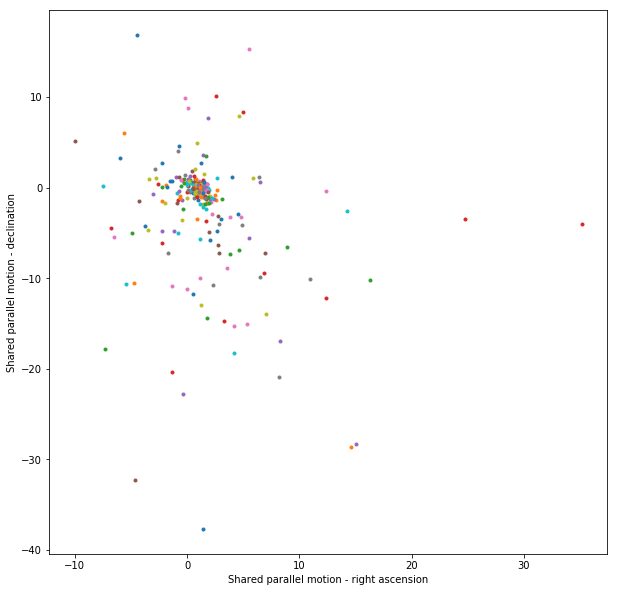

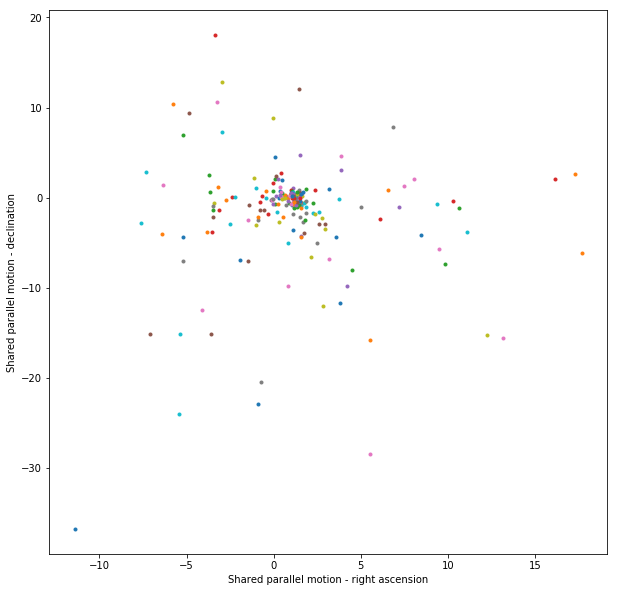

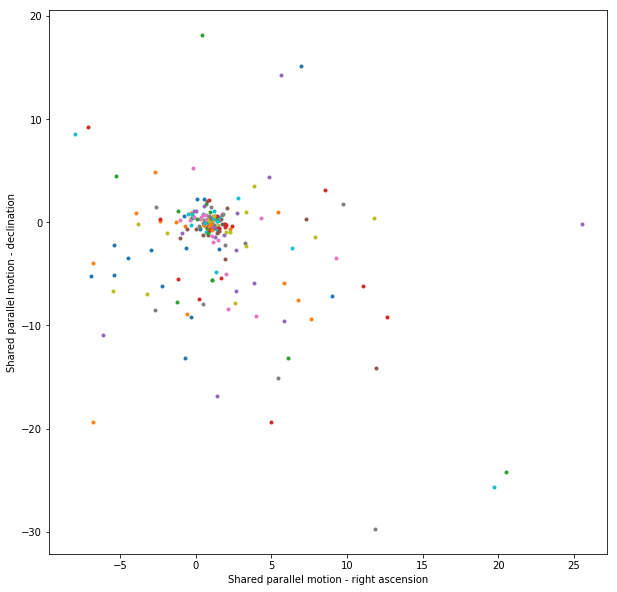

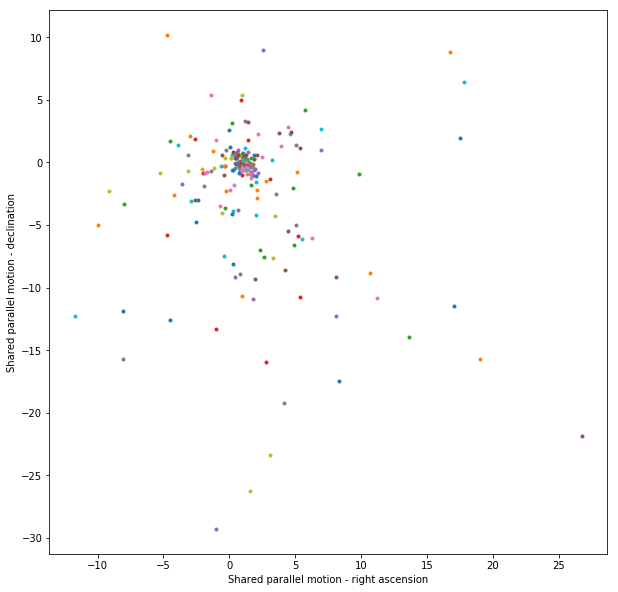

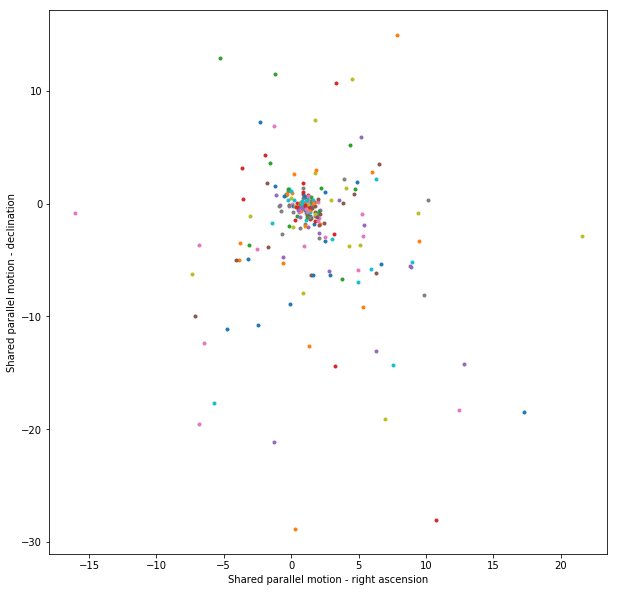

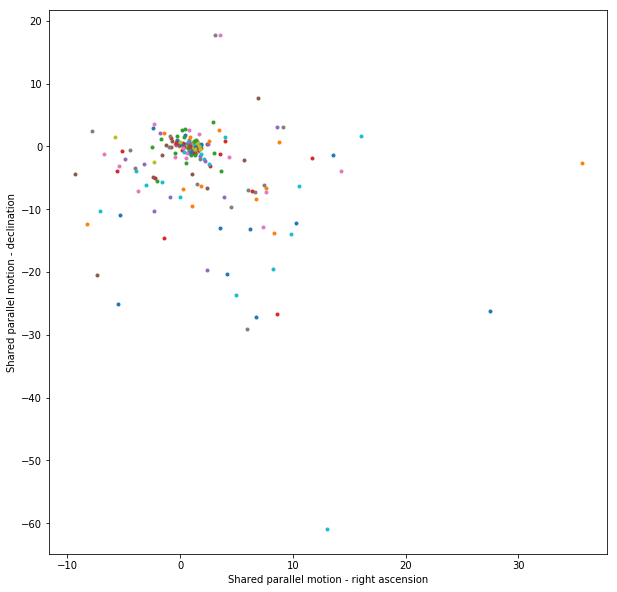

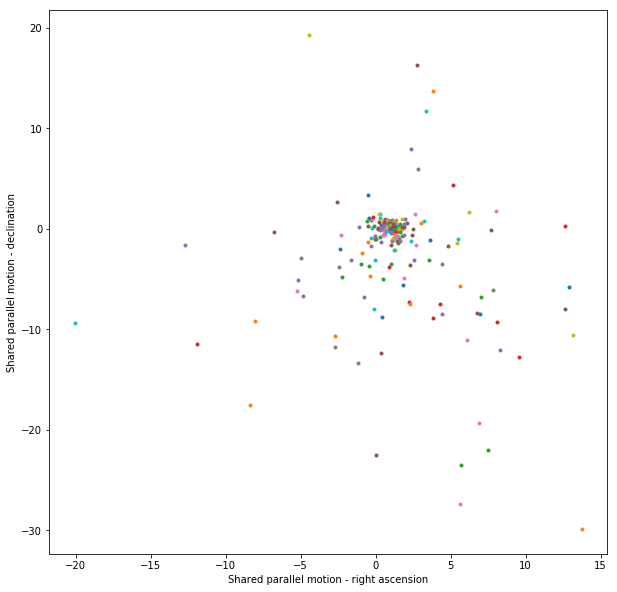

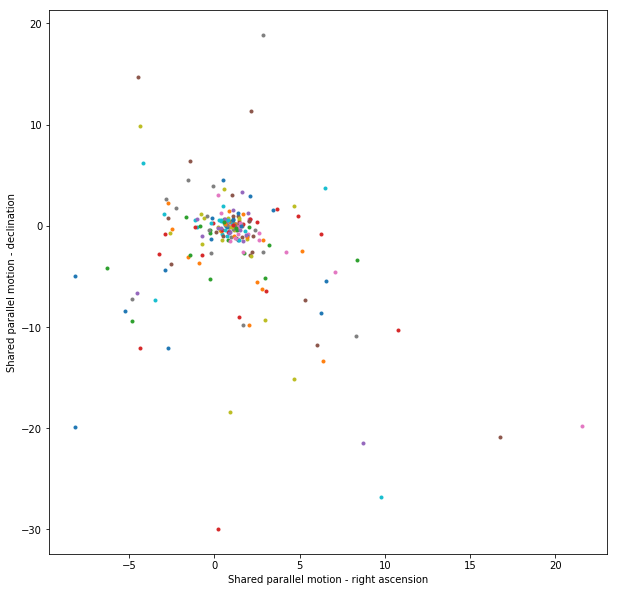

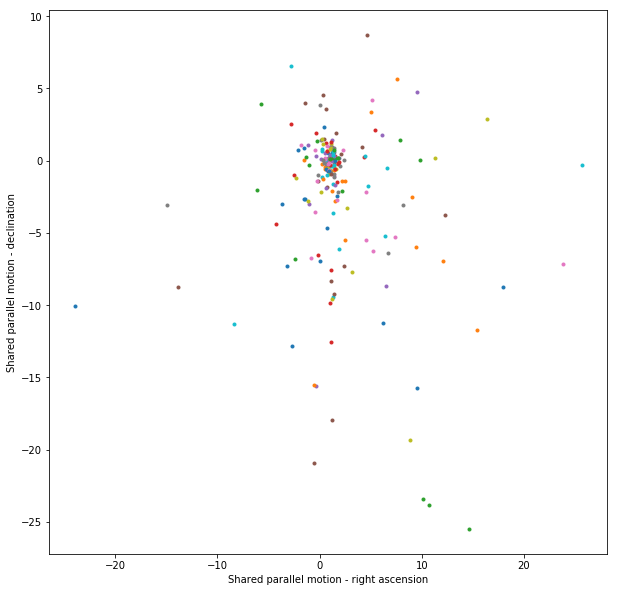

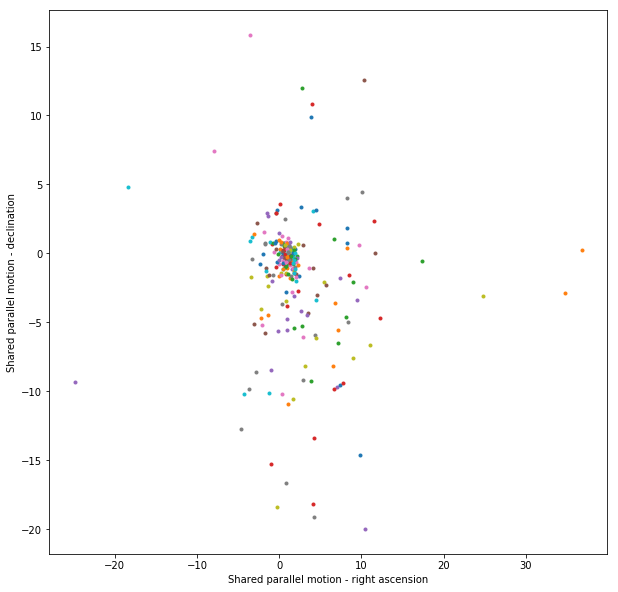

In [24]:
fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab1['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab2['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab3['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab4['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab5['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab6['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab7['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab8['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab9['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

fig, axs = plt.subplots(figsize = (10,10))
for chunk in btab10['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

##### The file `matchedWithRvs.fits` uses the file made earlier (`matchedPairData.fits`) cross-referenced with some confirmed Rvs in the region

In [25]:
enhanceTab = Table.read('c:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\data\\matchedWithRvs.fits')
enhanceTab

ra1,dec1,pmra1,pmdec1,projected_ra1,projected_dec1,parallax1,rVelocity1,G1,bprp1,ra_err1,dec_err1,pmra_err1,pmdec_err1,parralax_err1,rv_err1,ra2,dec2,pmra2,pmdec2,projected_ra2,projected_dec2,parallax2,rVelocity2,G2,bprp2,ra_err2,dec_err2,pmra_err2,pmdec_err2,parralax_err2,rv_err2,ref_pmra,ref_pmdec,time,ra_1,dec_1,rv_1,rve_1,isbin_1,Separation_1,ra_2,dec_2,rv_2,rve_2,isbin_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,int16,float64
83.48251170091393,-4.797265264995391,0.6447739881206371,0.946648818204142,83.4824400593597,-4.797370448197414,2.446124574615641,nan,16.8622,2.7225971,0.0975906924092268,0.09586025503680433,0.2411820526140304,0.1982581688380465,0.13176411603228833,nan,83.48253321864347,-4.797049560919736,-0.07499483289390126,1.3499021915126073,83.48254155140268,-4.7971995500521265,2.479931510507315,nan,16.948454,2.6344328,0.1091233109154024,0.10085048692611268,0.2713176242934988,0.2537414393881067,0.13401914755570907,nan,0.284889577613368,1.1482755048583748,-400,83.482506,-4.797142,28.9363,0.386201,-1,0.44422500761004136,83.482506,-4.797142,28.9363,0.386201,-1,0.34681019841963845
84.53876810637198,-6.821279333750583,0.24341211743322042,-0.5376869219573865,84.53870725334262,-6.8211449120200935,2.555351015682546,nan,13.023477,2.278349,0.03657946680206794,0.043071152775523674,0.08480524907547862,0.08690065435335688,0.05314236868699175,nan,84.53840611426924,-6.824308421585931,-2.1650734999397305,-12.71708095634933,84.53894738264422,-6.8211291513468435,2.381508354627957,nan,18.831034,3.316311,0.218529866356268,0.24742385187365107,0.5494369682820555,0.5891574911896434,0.3027479997254582,nan,-0.9608306912532552,-6.627383939153358,-900,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,--,nan
84.50349454157684,-7.264919768031094,-0.010701943245293588,1.3953914020712481,84.50349959527226,-7.26557870285985,3.152727556491071,nan,15.249276,2.1309347,0.09954479511210143,0.0933556609361285,0.24836261730137532,0.20048602022075482,0.13085510796305624,nan,84.50335136108642,-7.265221329201588,0.11152819090463771,0.8443734708342436,84.50329869499626,-7.265620061118371,2.6833273594620985,nan,15.752002,2.3069115,0.08932226618754684,0.08195359697557524,0.19207466954507768,0.16359151484472476,0.10607502368011383,nan,0.050413123829672064,1.119882436452746,-1700,84.503448,-7.2650442,23.5248,0.120057,0,0.47779464343022504,84.503448,-7.2650442,23.5248,0.120057,0,0.7250625183653897
84.08028325875834,-5.0079025103820145,1.9289053108034433,0.10875771429393918,84.07921164469678,-5.0079629313344,2.380364991994506,nan,17.38141,3.2439833,0.09092217957386244,0.09248528687591666,0.22757602112369593,0.23283750486366234,0.11973001911974872,nan,84.07983711301937,-5.010653864554236,1.416340135215205,-4.906162244794249,84.07905025738869,-5.007928218862683,2.1517806811876303,nan,16.9702,2.341385,0.060584980841551686,0.061652922293499036,0.1503192418278543,0.1531460075089603,0.07901936980633972,nan,1.6726227230093242,-2.398702265250155,-2000,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,--,nan
83.85776095102422,-5.132364341100109,3.525223471317901,-0.6938061298633568,83.85521495629493,-5.131863258895208,2.507368734750781,nan,14.307585,2.1879883,0.02545239424027045,0.027579579759516835,0.058046045197556996,0.05561210751701419,0.03437069040242561,nan,83.85690201927144,-5.132569536849398,2.4404869156115954,-1.1889684760861023,83.85513944538795,-5.131710837394447,2.671313954363518,nan,15.432099,3.105173,0.08750562534712117,0.09272331631182928,0.20602097167940933,0.18852674170235675,0.12109833413754126,nan,2.982855193464748,-0.9413873029747294,-2600,83.85775,-5.1323762,28.0852,0.227183,0,0.05800344443789961

In [26]:
bi1 = enhanceTab['isbin_1']
bi2 = enhanceTab['isbin_2']

In [27]:
biIn1 = np.where(bi1 == 3)[0]
biIn2 = np.where(bi2 == 3)[0]
print(len(biIn1)+len(biIn2))

13


In [28]:
confirmed = Table.read('c:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\data\\oriona-allmembers.fits')
#confirmed
#It looks like I'm going to have to match this up against my own

In [29]:
#The product of these two being matched is enhancedMatchedConfirmedMembers.fits
confEnhance = Table.read('c:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\data\\enhancedMatchedConfirmedMembers.fits')
confEnhance

ra1,dec1,pmra1,pmdec1,projected_ra1,projected_dec1,parallax1,rVelocity1,G1,bprp1,ra_err1,dec_err1,pmra_err1,pmdec_err1,parralax_err1,rv_err1,ra2,dec2,pmra2,pmdec2,projected_ra2,projected_dec2,parallax2,rVelocity2,G2,bprp2,ra_err2,dec_err2,pmra_err2,pmdec_err2,parralax_err2,rv_err2,ref_pmra,ref_pmdec,time,ra_1,dec_1,rv_1,rve_1,isbin_1,Separation_1,ra_2,dec_2,rv_2,rve_2,isbin_2,Separation_1a,RA_1a,DEC_1a,apogee_1,grosschedl18_1,fang09_1,fang13_1,hsu12_1,hsu13_1,kounkel16_1,hasenberger16_1,pillitteri13_1,fang17_1,megeath12_1,kounkel17_1,rebull06_1,furesz08_1,getman05_1,hillenbrand97_1,dario10_1,dario12_1,kuhn14_1,getman14a_1,getman14b_1,sicilia-aguilar05_1,Separation_1b,RA_2a,DEC_2a,apogee_2,grosschedl18_2,fang09_2,fang13_2,hsu12_2,hsu13_2,kounkel16_2,hasenberger16_2,pillitteri13_2,fang17_2,megeath12_2,kounkel17_2,rebull06_2,furesz08_2,getman05_2,hillenbrand97_2,dario10_2,dario12_2,kuhn14_2,getman14a_2,getman14b_2,sicilia-aguilar05_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64
83.48251170091393,-4.797265264995391,0.6447739881206371,0.946648818204142,83.4824400593597,-4.797370448197414,2.446124574615641,nan,16.8622,2.7225971,0.0975906924092268,0.09586025503680433,0.2411820526140304,0.1982581688380465,0.13176411603228833,nan,83.48253321864347,-4.797049560919736,-0.07499483289390126,1.3499021915126073,83.48254155140268,-4.7971995500521265,2.479931510507315,nan,16.948454,2.6344328,0.1091233109154024,0.10085048692611268,0.2713176242934988,0.2537414393881067,0.13401914755570907,nan,0.284889577613368,1.1482755048583748,-400,83.482506,-4.797142,28.9363,0.386201,-1,0.44422500761004136,83.482506,-4.797142,28.9363,0.386201,-1,0.34681019841963845,83.48250579833984,-4.797142028808594,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0.44415530804199466,83.48250579833984,-4.797142028808594,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0.3471140324808718
84.53876810637198,-6.821279333750583,0.24341211743322042,-0.5376869219573865,84.53870725334262,-6.8211449120200935,2.555351015682546,nan,13.023477,2.278349,0.03657946680206794,0.043071152775523674,0.08480524907547862,0.08690065435335688,0.05314236868699175,nan,84.53840611426924,-6.824308421585931,-2.1650734999397305,-12.71708095634933,84.53894738264422,-6.8211291513468435,2.381508354627957,nan,18.831034,3.316311,0.218529866356268,0.24742385187365107,0.5494369682820555,0.5891574911896434,0.3027479997254582,nan,-0.9608306912532552,-6.627383939153358,-900,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,--,nan,84.5387950028182,-6.821276737886405,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.09659492271329072,nan,nan,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,nan
84.50349454157684,-7.264919768031094,-0.010701943245293588,1.3953914020712481,84.50349959527226,-7.26557870285985,3.152727556491071,nan,15.249276,2.1309347,0.09954479511210143,0.0933556609361285,0.24836261730137532,0.20048602022075482,0.13085510796305624,nan,84.50335136108642,-7.265221329201588,0.11152819090463

In [30]:
aa1 = np.where(confEnhance['apogee_1'] == True)[0]
bb1 = np.where(confEnhance['grosschedl18_1'] == True)[0]
cc1 = np.where(confEnhance['fang09_1'] == True)[0]
dd1 = np.where(confEnhance['fang13_1'] == True)[0]
ee1 = np.where(confEnhance['hsu12_1'] == True)[0]
ff1 = np.where(confEnhance['hsu13_1'] == True)[0]
gg1 = np.where(confEnhance['kounkel16_1'] == True)[0]
hh1 = np.where(confEnhance['hasenberger16_1'] == True)[0]
ii1= np.where(confEnhance['pillitteri13_1'] == True)[0]
jj1= np.where(confEnhance['fang17_1'] == True)[0]
kk1= np.where(confEnhance['megeath12_1'] == True)[0]
ll1= np.where(confEnhance['kounkel17_1'] == True)[0]
mm1= np.where(confEnhance['rebull06_1'] == True)[0]
nn1= np.where(confEnhance['furesz08_1'] == True)[0]
oo1= np.where(confEnhance['getman05_1'] == True)[0]
pp1= np.where(confEnhance['hillenbrand97_1'] == True)[0]
qq1= np.where(confEnhance['dario10_1'] == True)[0]
rr1= np.where(confEnhance['dario12_1'] == True)[0]
ss1= np.where(confEnhance['kuhn14_1'] == True)[0]
tt1= np.where(confEnhance['getman14a_1'] == True)[0]
uu1= np.where(confEnhance['getman14b_1'] == True)[0]
vv1= np.where(confEnhance['sicilia-aguilar05_1'] == True)[0]

aa2 = np.where(confEnhance['apogee_2'] == True)[0]
bb2 = np.where(confEnhance['grosschedl18_2'] == True)[0]
cc2 = np.where(confEnhance['fang09_2'] == True)[0]
dd2 = np.where(confEnhance['fang13_2'] == True)[0]
ee2 = np.where(confEnhance['hsu12_2'] == True)[0]
ff2 = np.where(confEnhance['hsu13_2'] == True)[0]
gg2 = np.where(confEnhance['kounkel16_2'] == True)[0]
hh2= np.where(confEnhance['hasenberger16_2'] == True)[0]
ii2= np.where(confEnhance['pillitteri13_2'] == True)[0]
jj2= np.where(confEnhance['fang17_2'] == True)[0]
kk2= np.where(confEnhance['megeath12_2'] == True)[0]
ll2= np.where(confEnhance['kounkel17_2'] == True)[0]
mm2= np.where(confEnhance['rebull06_2'] == True)[0]
nn2= np.where(confEnhance['furesz08_2'] == True)[0]
oo2= np.where(confEnhance['getman05_2'] == True)[0]
pp2= np.where(confEnhance['hillenbrand97_2'] == True)[0]
qq2= np.where(confEnhance['dario10_2'] == True)[0]
rr2= np.where(confEnhance['dario12_2'] == True)[0]
ss2= np.where(confEnhance['kuhn14_2'] == True)[0]
tt2= np.where(confEnhance['getman14a_2'] == True)[0]
uu2= np.where(confEnhance['getman14b_2'] == True)[0]
vv2= np.where(confEnhance['sicilia-aguilar05_2'] == True)[0]

In [31]:
conf1 = np.unique(np.concatenate((aa1,bb1,cc1,dd1,ee1,ff1,gg1,hh1,ii1,jj1,ll1,mm1,nn1,oo1,pp1,qq1,rr1,ss1,tt1,uu1,vv1)))
conf2 = np.unique(np.concatenate((aa2,bb2,cc2,dd2,ee2,ff2,gg2,hh2,ii2,jj2,ll2,mm2,nn2,oo2,pp2,qq2,rr2,ss2,tt2,uu2,vv2)))

print(conf1)
print(conf2)

[  0   1   2   3   5   6   7   9  13  16  18  19  20  21  23  24  28  30
  31  33  34  40  42  43  46  50  51  57  58  61  62  68  69  73  75  76
  77  78  80  81  82  83  86  87  90  91  92  93  94  95  99 100 101 104
 105 107 108 109 110 112 113 114 115 116 119 122 123 125 126 127 128 129
 131 132 133 134 135 136 137 138 141 142 145 146 148 150 151 152 156 159
 161 164 165 166 170 171 173 174 177 179 180 181 182 184 185 189 191 192
 197 198 199 200 201 202 203 206 208 209 210 211 214 215 218 220 223 228
 229 230 232 238 239 243 247 250 251 252 253 254 257 258 259 260 261 262
 263 264 265 266 270 271 272 274 275 276 278 279 283 287 289 290 291 292
 293 298 301 304 305 306 307 315 316 317 319 320 321 322 327 328 329 334
 336 338 339 340 344 347 348 351 357 364 365 367 368 371 372 373 376 379
 381 382 383 385 386 388 389 391 392 398 400 403 404 405 406 408 409 410
 414 415 416 418 419 421 422 426 427 430 431 436 437 438 439]
[  0   2   4   6   7  13  16  18  23  26  28  30  31  32  33  

In [32]:
bothConf = np.intersect1d(conf1, conf2)

In [33]:
print(bothConf)
print(len(bothConf))

[  0   2   6   7  13  16  18  23  28  30  31  33  34  42  50  57  58  73
  75  76  78  82  86  90  91  93  94  95  99 101 104 109 110 116 122 123
 126 127 128 131 133 135 136 137 141 142 145 146 150 152 159 161 171 177
 179 181 182 189 191 198 200 201 202 203 209 214 223 228 229 230 238 239
 243 250 254 257 258 260 261 262 263 266 271 272 274 275 276 278 283 290
 293 298 304 315 316 320 322 328 329 339 340 344 348 357 365 371 372 381
 382 385 388 389 403 409 410 415 416 419 421 422 427 438]
122


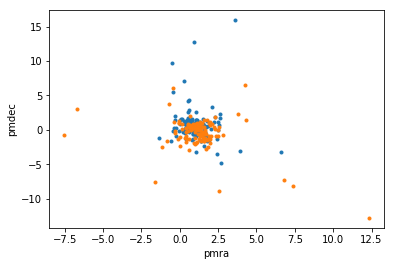

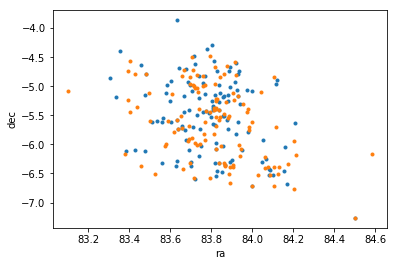

In [34]:
plt.plot(confEnhance['pmra1'][bothConf], confEnhance['pmdec1'][bothConf], '.')
plt.plot(confEnhance['pmra2'][bothConf], confEnhance['pmdec2'][bothConf], '.')
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.show()

plt.plot(confEnhance['ra1'][bothConf], confEnhance['dec1'][bothConf], '.')
plt.plot(confEnhance['ra2'][bothConf], confEnhance['dec2'][bothConf], '.')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()
#These are all the ones that are confirmed in the cluster

In [39]:
"""plt.plot(confEnhance['pmra1'], confEnhance['pmdec1'], '.')
plt.plot(confEnhance['pmra2'], confEnhance['pmdec2'], '.')
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.show()

plt.plot(confEnhance['ra1'], confEnhance['dec1'], '.')
plt.plot(confEnhance['ra2'], confEnhance['dec2'], '.')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()"""
print()

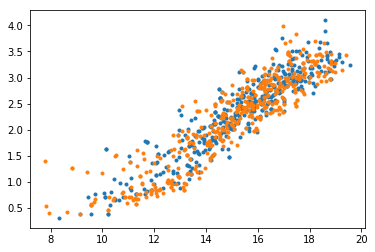

In [36]:
plt.plot(confEnhance['G1'], confEnhance['bprp1'], '.')
plt.plot(confEnhance['G2'], confEnhance['bprp2'], '.')
plt.show()

In [37]:
bi1 = confEnhance['isbin_1']
bi2 = confEnhance['isbin_2']

biIn1 = np.where(bi1 == 3)[0]
biIn2 = np.where(bi2 == 3)[0]
blist = np.concatenate((biIn1, biIn2))
blist

array([ 56, 134, 334, 368, 409, 127, 141, 146, 258, 297, 382, 399, 415],
      dtype=int64)

From here I have a lot of work to do in comparing the proper motion of the relevant stars and seeing what happens. This should eventually get cleaned up

In [41]:
bab = bothConf[0]
print(bab)



0
